In [3]:

import os, time, random
from typing import List, Tuple, Callable, Optional
import numpy as np
rng = random.Random(1)
np.random.seed(1)

def is_symmetric(M: np.ndarray, tol: float = 1e-9) -> bool:
    return np.allclose(M, M.T, atol=tol)

def cycle_cost(M: np.ndarray, tour: List[int]) -> float:
    """Costo del tour CHIUSO."""
    w = 0.0
    n = len(tour)
    for i in range(n - 1):
        w += M[tour[i], tour[i + 1]]
    w += M[tour[-1], tour[0]]
    return float(w)

def normalize_start_at_zero(tour: List[int]) -> List[int]:
    """Ruota la permutazione per iniziare da 0 (comodo per confronti)."""
    i0 = tour.index(0)
    return tour[i0:] + tour[:i0]


def precompute_neighbors(M: np.ndarray) -> Tuple[List[List[int]], List[int]]:
    """Per ogni nodo: lista dei vicini ordinati (escluso se stesso) e il 2° più vicino."""
    n = M.shape[0]
    neighbors = []
    second_best = []
    for i in range(n):
        order = np.argsort(M[i]).tolist()
        order.remove(i)
        neighbors.append(order)
        second_best.append(order[1] if len(order) > 1 else order[0])
    return neighbors, second_best

def greedy_nn(M: np.ndarray, start: int, neighbors: List[List[int]], rand_eps: float=0.1) -> List[int]:
    """Nearest-Neighbor con piccola randomizzazione."""
    n = M.shape[0]
    unvisited = set(range(n))
    tour = [start]
    unvisited.remove(start)
    while unvisited:
        cur = tour[-1]
        if rng.random() < rand_eps:
            nxt = rng.choice(list(unvisited))
        else:
            for v in neighbors[cur]:
                if v in unvisited:
                    nxt = v
                    break
        tour.append(nxt)
        unvisited.remove(nxt)
    return tour

def greedy_anti_isolati(M: np.ndarray, start: int,
                        neighbors: List[List[int]],
                        second_best: List[int],
                        rand_eps: float=0.1) -> List[int]:
    """
    Evita di lasciare nodi 'orfani':
    scegli un nodo v il cui nearest(v) == ultimo, e tra questi massimizza (dist(second_best(v)) - dist(nearest(v))).
    Con precompute è O(n^2).
    """
    n = M.shape[0]
    unvisited = set(range(n))
    tour = [start]
    unvisited.remove(start)

    while unvisited:
        if rng.random() < rand_eps:
            nxt = rng.choice(list(unvisited))
        else:
            last = tour[-1]
            cand = []
            for v in list(unvisited):
                if neighbors[v][0] == last:
                    d1 = M[v, last]
                    d2 = M[v, second_best[v]]
                    cand.append((d2 - d1, v))
            if cand:
                cand.sort(reverse=True)
                nxt = cand[0][1]
            else:
                for v in neighbors[last]:
                    if v in unvisited:
                        nxt = v
                        break
        tour.append(nxt); unvisited.remove(nxt)
    return tour

def seed_population(M: np.ndarray, pop_size: int) -> List[List[int]]:
    n = M.shape[0]
    neighbors, second_best = precompute_neighbors(M)
    pop = []
    q_greedy = max(2, int(0.6 * pop_size))
    starts = [rng.randrange(n) for _ in range(q_greedy)]
    for i, s in enumerate(starts):
        if is_symmetric(M):
            tour = greedy_nn(M, s, neighbors, rand_eps=0.05)
        else:
            tour = greedy_anti_isolati(M, s, neighbors, second_best, rand_eps=0.05)
        pop.append(normalize_start_at_zero(tour))
    while len(pop) < pop_size:
        perm = list(range(n)); rng.shuffle(perm)
        pop.append(normalize_start_at_zero(perm))
    return pop


def two_opt_first(M: np.ndarray, tour: List[int], max_swaps: int = 50) -> List[int]:
    """Applica fino a max_swaps mosse 2-opt migliorative. O(max_swaps * n^2) con delta O(1)."""
    n = len(tour)
    def cost(i, j): return M[i, j]
    swaps = 0
    improved = True
    while improved and swaps < max_swaps:
        improved = False
        for i in range(1, n - 2):
            a, b = tour[i - 1], tour[i]
            for k in range(i + 1, n - 0):  
                c, d = tour[k % n], tour[(k + 1) % n] if (k + 1) < n else tour[0]
                delta = (cost(a, c) + cost(b, d)) - (cost(a, b) + cost(c, d))
                if delta < -1e-12:
                    if i < k:
                        tour[i:k+1] = reversed(tour[i:k+1])
                    else:
                        seg = tour[i:] + tour[:k+1]
                        seg.reverse()
                        tour[i:] = seg[:n - i]
                        tour[:k+1] = seg[n - i:]
                    swaps += 1
                    improved = True
                    if swaps >= max_swaps:
                        break
            if improved or swaps >= max_swaps:
                break
    return normalize_start_at_zero(tour)

def local_search_asymmetric(M: np.ndarray, tour: List[int], max_moves: int = 50) -> List[int]:
    """
    Node Insertion (Shift) Local Search for Asymmetric TSP.
    Moves a single node to a better position. Preserves direction of edges.
    """
    n = len(tour)
    best_cost = cycle_cost(M, tour)
    moves = 0
    improved = True
    
    # Track indices to avoid list scans
    
    while improved and moves < max_moves:
        improved = False
         
        for i in range(n):
            node = tour[i]
            prev_i = tour[(i - 1) % n]
            next_i = tour[(i + 1) % n]
            
            # Cost removed by taking 'node' out
            removal_delta = -M[prev_i, node] - M[node, next_i] + M[prev_i, next_i]
            
            # Try inserting 'node' after node 'j'
            best_move_delta = 0
            best_j = -1
            
            # Scan potential insertion points
            for j in range(n):
                if j == i or j == (i - 1) % n: continue
                
                u = tour[j]
                v = tour[(j + 1) % n]
                
                # Insert between u and v
                # Remove: (u -> v)
                # Add: (u -> node), (node -> v)
                insertion_delta = -M[u, v] + M[u, node] + M[node, v]
                
                total_delta = removal_delta + insertion_delta
                
                if total_delta < best_move_delta - 1e-9:
                    best_move_delta = total_delta
                    best_j = j
            
            if best_j != -1:
                # Apply move
                tour.pop(i)
                # If insertion index j was after i, it shifted down by 1
                # If j < i, index is stable
                insert_idx = best_j + 1 if best_j < i else best_j
                tour.insert(insert_idx, node)
                
                best_cost += best_move_delta
                moves += 1
                improved = True
                if moves >= max_moves: break      
    return normalize_start_at_zero(tour)


def erx(M: np.ndarray, p1: List[int], p2: List[int]) -> List[int]:
    """ERX leggero: preserva adiacenze (2 per genitore, max 4)."""
    n = len(p1)
    adj = [set() for _ in range(n)]
    def add_edges(p):
        for i, v in enumerate(p):
            adj[v].add(p[(i - 1) % n])
            adj[v].add(p[(i + 1) % n])
    add_edges(p1); add_edges(p2)

    remaining = set(p1)
    cur = rng.choice(p1)
    child = [cur]; remaining.remove(cur)
    for s in adj: s.discard(cur)

    while remaining:
        candidates = [v for v in adj[cur] if v in remaining]
        if candidates:
            min_deg = min(len(adj[v]) for v in candidates)
            C = [v for v in candidates if len(adj[v]) == min_deg]
            if len(C) > 1:
                nxt = min(C, key=lambda v: M[cur, v])
            else:
                nxt = C[0]
        else:
            nxt = min(remaining, key=lambda v: M[cur, v])
        child.append(nxt); remaining.remove(nxt)
        for s in adj: s.discard(nxt)
        cur = nxt
    return normalize_start_at_zero(child)

def ox(parent1: List[int], parent2: List[int]) -> List[int]:
    """Order Crossover (OX1) per ATSP: copia segmento da p1, riempi in ordine da p2."""
    n = len(parent1)
    i, j = sorted(rng.sample(range(n), 2))
    child = [-1] * n
    child[i:j+1] = parent1[i:j+1]
    used = set(child[i:j+1])
    pos = (j + 1) % n
    for k in range(n):
        v = parent2[(j + 1 + k) % n]
        if v not in used:
            child[pos] = v
            used.add(v)
            pos = (pos + 1) % n
    return normalize_start_at_zero(child)

def mutation_inversion(tour: List[int]) -> List[int]:
    i, j = sorted(rng.sample(range(len(tour)), 2))
    tour = tour[:i] + list(reversed(tour[i:j+1])) + tour[j+1:]
    return normalize_start_at_zero(tour)

def mutation_insertion(tour: List[int]) -> List[int]:
    i, j = rng.sample(range(len(tour)), 2)
    v = tour.pop(i)
    tour.insert(j, v)
    return normalize_start_at_zero(tour)


def tournament_select(pop: List[List[int]], fitness: List[float], k: int=3) -> int:
    idxs = rng.sample(range(len(pop)), k)
    return min(idxs, key=lambda i: fitness[i])

def evolutionary_tsp(
    M: np.ndarray,
    pop_size: int = 80,
    offspring_per_iter: int = 40,
    p_mut: float = 0.30,
    two_opt_moves: int = 40,
    time_limit_s: Optional[float] = None,
    max_iters: int = 2000,
    tournament_k: int = 4,
) -> Tuple[List[int], float]:
    """EA steady-state con 2-opt sui figli e crossover adattato a simmetria."""
    n = M.shape[0]
    symmetric = is_symmetric(M)

    pop = seed_population(M, pop_size)
    fitness = [cycle_cost(M, t) for t in pop]

    best_idx = int(np.argmin(fitness))
    best_tour = list(pop[best_idx])
    best_cost = fitness[best_idx]
    
    history = [best_cost]
    pop_indices = list(range(pop_size))
    
    start_time = time.time()
    it = 0
    while it < max_iters and (time_limit_s is None or (time.time() - start_time) < time_limit_s):
        children = []
        children_fits = []
        for _ in range(offspring_per_iter):
            p1_idx = tournament_select(pop_indices, fitness, k=tournament_k)
            p1 = pop[p1_idx]
           
            if rng.random() < p_mut:
                child = mutation_inversion(list(p1)) if symmetric else mutation_insertion(list(p1))
            else:    
                p2_idx = tournament_select(pop_indices, fitness, k=tournament_k)
                p2 = pop[p2_idx]
                if symmetric:
                    child = erx(M, p1, p2)
                else: 
                    child = ox(p1, p2)       
            if symmetric:
                child = two_opt_first(M, child, max_swaps=two_opt_moves)
            else: 
                child = local_search_asymmetric(M, child, max_moves=two_opt_moves)

            child_cost = cycle_cost(M, child)
            children.append(child)
            children_fits.append(child_cost)
        for c, c_cost in zip(children, children_fits):
            worst_idx = int(np.argmax(fitness))
            if c_cost < fitness[worst_idx]:
                pop[worst_idx] = c
                fitness[worst_idx] = c_cost
                
                if c_cost < best_cost:
                    best_cost = c_cost
                    best_tour = list(c)
        
        history.append(best_cost)
        it += 1

    return best_tour, best_cost, history


def solve_problems_dir(path: str, seconds_per_instance: Optional[float]=None) -> None:
    files = sorted([f for f in os.listdir(path) if f.endswith(".npy")])
    for fname in files:
        M = np.load(os.path.join(path, fname))
        n = M.shape[0]
        if seconds_per_instance is None:
            tl = max(5.0, min(60.0, 0.08 * n + 0.015 * n * np.log(max(3, n))))
        else:
            tl = seconds_per_instance
        tour, cost = evolutionary_tsp(
            M,
            pop_size= max(40, min(120, n // 5)),
            offspring_per_iter= max(20, min(80, n // 4)),
            p_mut=0.30 if is_symmetric(M) else 0.40,
            two_opt_moves= max(20, min(120, n // 5)),
            time_limit_s= tl,
            max_iters= 10**9, 
            tournament_k= 4
        )
        print(f"{fname:>10s} | n={n:4d} | symmetric={is_symmetric(M)} | best={cost:10.2f}")

In [ ]:
if __name__ == "__main__":
    problems_dir = "lab2"
    if os.path.isdir(problems_dir):
        solve_problems_dir(problems_dir)
    else:
        print("Metti le istanze .npy nella cartella 'problems' o passa un path diverso.")


--- Problem: problem_r2_10.npy (n=10) ---
Time budget: 5.0s
Running Patched Memetic EA...
Final Score: -411.70


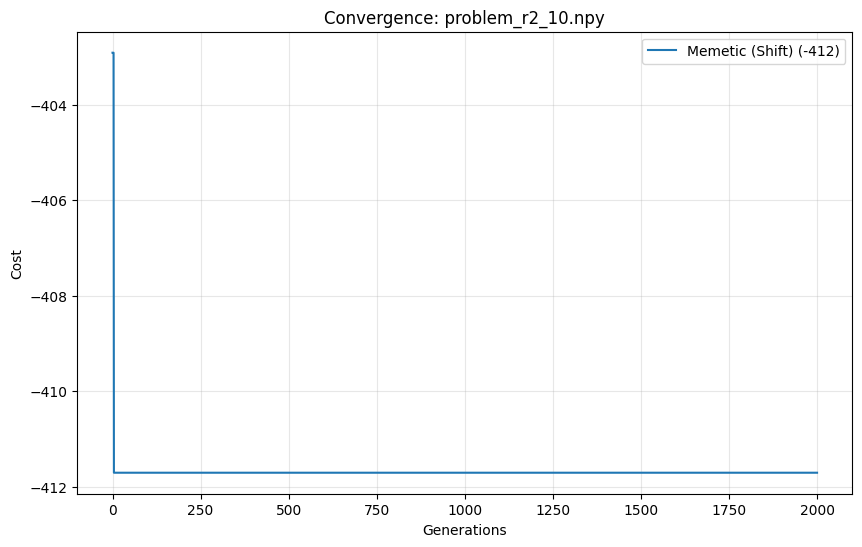


--- Problem: problem_r2_100.npy (n=100) ---
Time budget: 5.0s
Running Patched Memetic EA...
Final Score: -4497.92


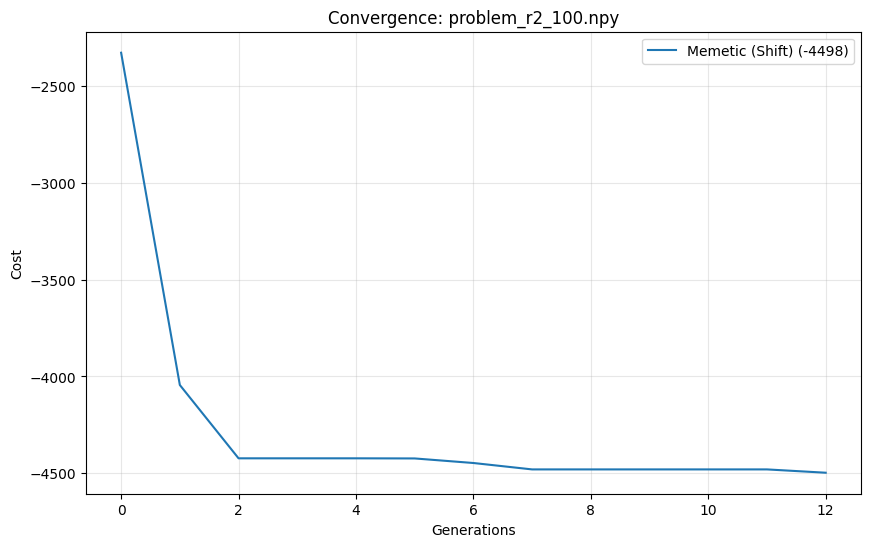


--- Problem: problem_r2_1000.npy (n=1000) ---
Time budget: 50.0s
Running Patched Memetic EA...
Final Score: -46254.03


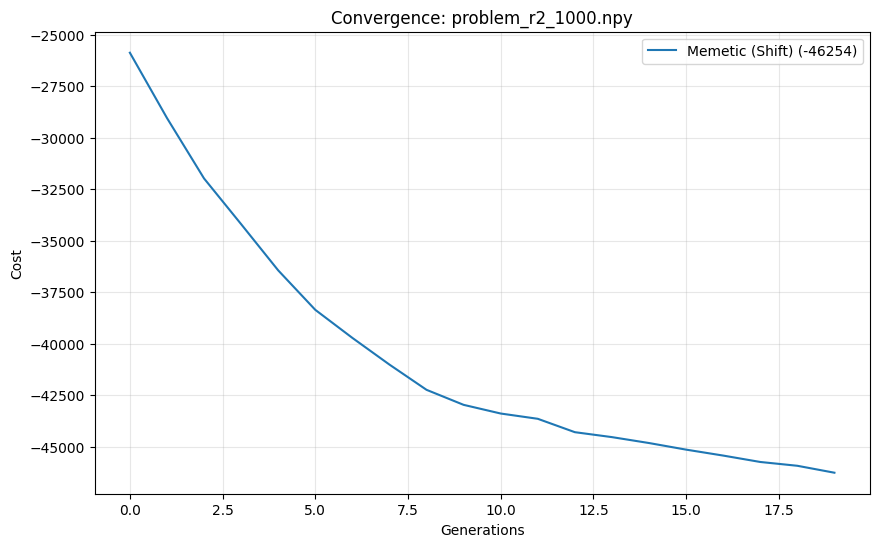


--- Problem: problem_r2_20.npy (n=20) ---
Time budget: 5.0s
Running Patched Memetic EA...
Final Score: -855.06


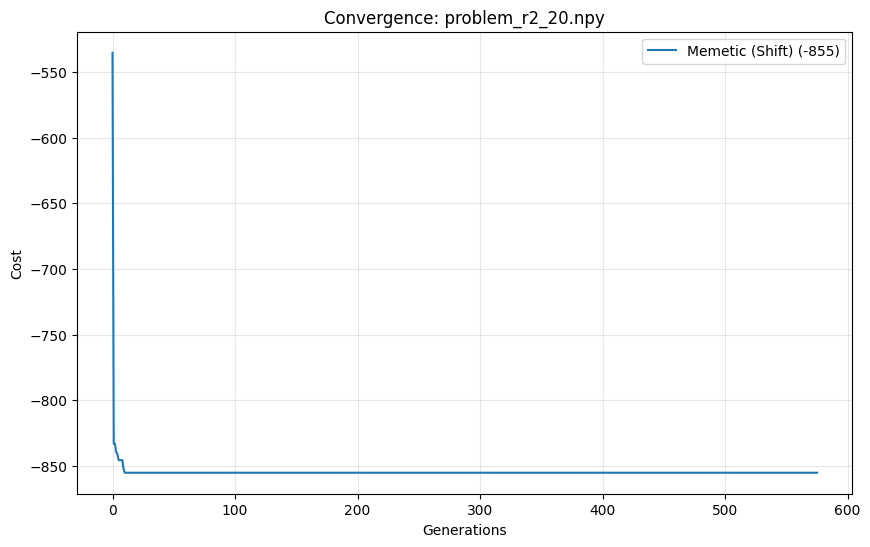


--- Problem: problem_r2_200.npy (n=200) ---
Time budget: 10.0s
Running Patched Memetic EA...
Final Score: -9083.05


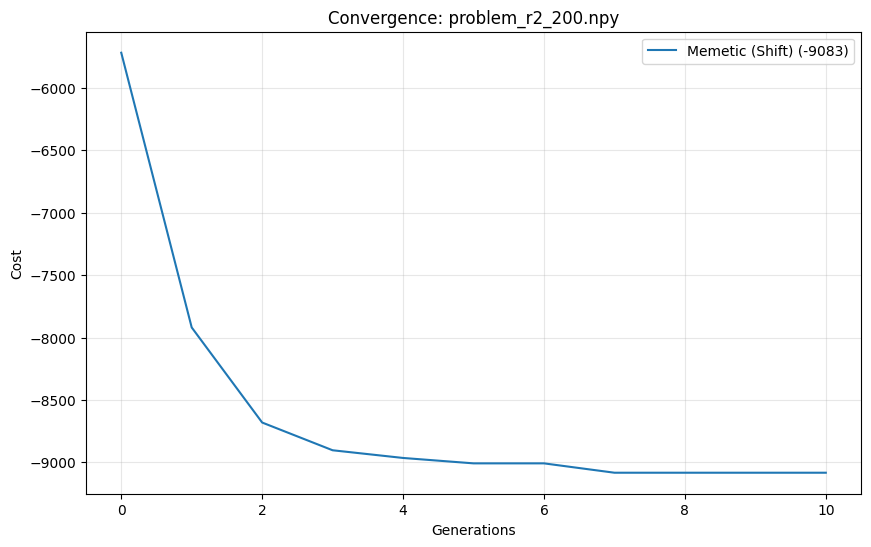


--- Problem: problem_r2_50.npy (n=50) ---
Time budget: 5.0s
Running Patched Memetic EA...
Final Score: -2278.41


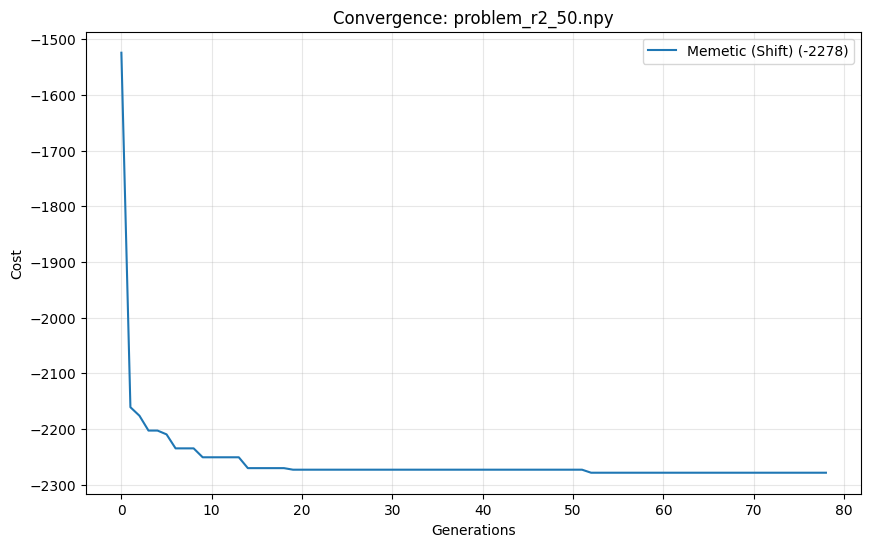


--- Problem: problem_r2_500.npy (n=500) ---
Time budget: 25.0s
Running Patched Memetic EA...
Final Score: -22832.29


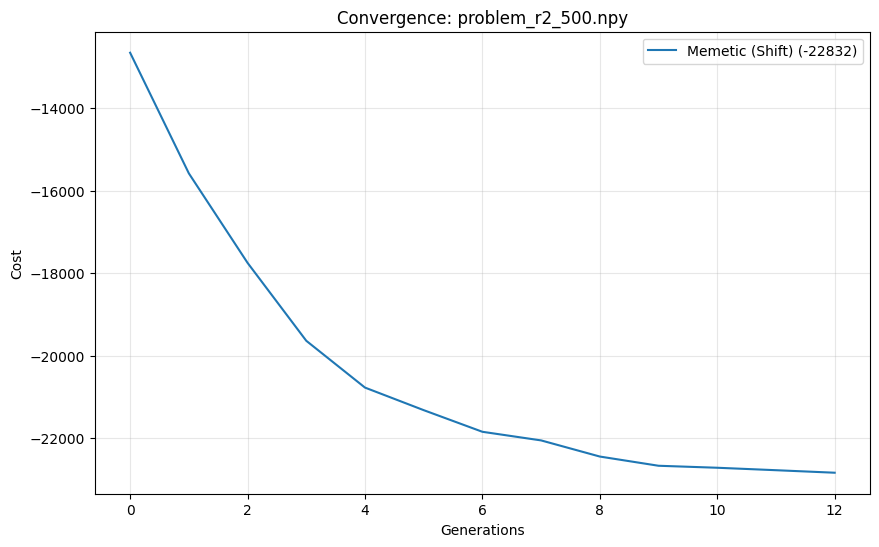

In [ ]:
import matplotlib.pyplot as plt

def review():
    problems_dir = "lab2"
    # Filter for r2 instances as requested for comparison
    files = sorted([f for f in os.listdir(problems_dir) if "r2" in f and f.endswith(".npy")])
    
    if not files:
        print("No r2 instances found in lab2/.")
        return

    for fname in files:
        path = os.path.join(problems_dir, fname)
        M = np.load(path)
        n = M.shape[0]
        print(f"\n--- Problem: {fname} (n={n}) ---")
        
        time_budget = max(5.0, n / 20.0)
        print(f"Time budget: {time_budget:.1f}s")
        
        print("Running Patched Memetic EA...")
        _, cost, hist = evolutionary_tsp(M, time_limit_s=time_budget)
        print(f"Final Score: {cost:.2f}")
        
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(hist, label=f"Memetic (Shift) ({cost:.0f})")
        plt.title(f"Convergence: {fname}")
        plt.xlabel("Generations")
        plt.ylabel("Cost")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
if __name__ == "__main__":
    review()

Results using 2-opt for R2: 
- R2_10 = -411.70
- R2_100 = -4223.86
- R2_1000 = -27853
- R2_20 = -775.67
- R2_200.npy = -6381.51 
- R2_50.npy = -1981.24 
- R2_500 = -13816.43 

Results using Node Shift for R2:

- R2_10 = -411.70
- R2_100 = -4497.92
- R2_1000 = -46254.03
- R2_20 = -855.06
- R2_200.npy = -9083.05
- R2_50.npy = -2278.41
- R2_500 = -22832.29